In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau , EarlyStopping

In [2]:
# Load the dataset
df = pd.read_csv('sufffle_image.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [3]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [4]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 16

In [5]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 27120 validated image filenames belonging to 3 classes.
Found 3390 validated image filenames belonging to 3 classes.


In [6]:
# Build DenseNet-121 model with ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

In [7]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1/conv[0][0]']   

In [8]:
for layer in base_model.layers[:-2]:
    layer.trainable = False

In [9]:
# Adding my custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

In [10]:
# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1/conv[0][0]']         

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv2_block5_1_relu (Activatio  (None, 45, 45, 128)  0          ['conv2_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block5_2_conv (Conv2D)   (None, 45, 45, 32)   36864       ['conv2_block5_1_relu[0][0]']    
                                                                                                  
 conv2_block5_concat (Concatena  (None, 45, 45, 224)  0          ['conv2_block4_concat[0][0]',    
 te)                                                              'conv2_block5_2_conv[0][0]']    
                                                                                                  
 conv2_block6_0_bn (BatchNormal  (None, 45, 45, 224)  896        ['conv2_block5_concat[0][0]']    
 ization)                                                                                         
          

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [14]:
epochs = 100

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)
model.save('transfer_VGG.h5')

C:\Users\Iftek\AppData\Local\Temp\ipykernel_22932\4127188724.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
1695/1695 [==============================] - 850s 483ms/step - loss: 0.3792 - accuracy: 0.8532 - val_loss: 0.2538 - val_accuracy: 0.9046 - lr: 0.0010
Epoch 2/100
1695/1695 [==============================] - 812s 479ms/step - loss: 0.2948 - accuracy: 0.8824 - val_loss: 0.2153 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 3/100
1695/1695 [==============================] - 772s 456ms/step - loss: 0.2782 - accuracy: 0.8921 - val_loss: 0.2373 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 4/100
1695/1695 [==============================] - 744s 439ms/step - loss: 0.2668 - accuracy: 0.8955 - val_loss: 0.2702 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 5/100
1695/1695 [==============================] - 769s 453ms/step - loss: 0.2616 - accuracy: 0.8982 - val_loss: 0.2716 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 6/100
1695/1695 [==============================] - 763s 450ms/step - loss: 0.2486 - accuracy: 0.9042 - val_loss: 0.1894 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 7/100
1695/1695 [=====

In [15]:
actual_epochs = len(history.history['loss'])

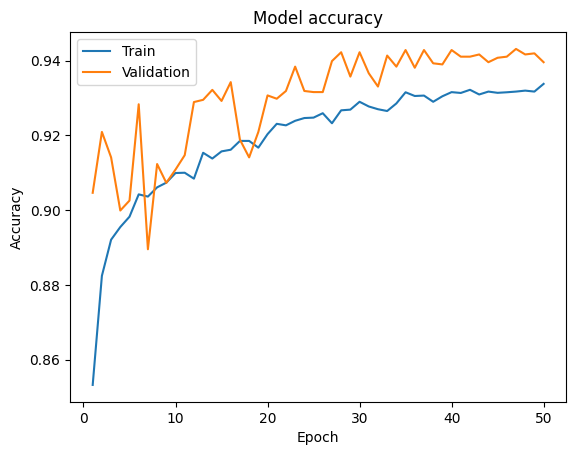

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

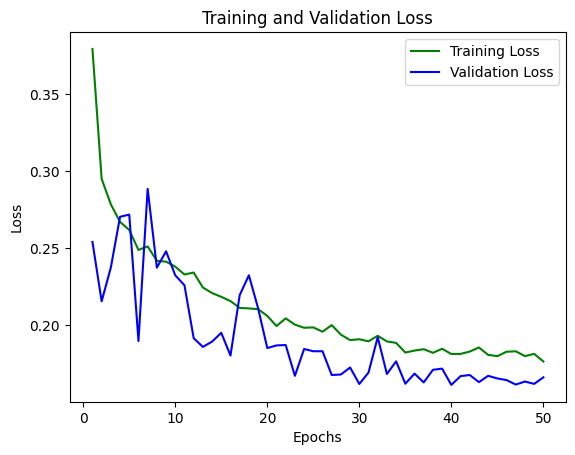

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename,category
0,CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
1,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
2,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
3,Datasets\Pneumonia\Viral Pneumonia\images\pers...,Viral Pneumonia
4,CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
...,...,...
3386,Datasets\Pneumonia\Viral Pneumonia\images\pers...,Viral Pneumonia
3387,CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
3388,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
3389,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal


In [19]:
nb_samples = test_df.shape[0]

In [20]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 3391 validated image filenames belonging to 3 classes.


In [21]:
import numpy as np

In [22]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
predict

C:\Users\Iftek\AppData\Local\Temp\ipykernel_22932\1469141313.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


array([[7.3727143e-01, 2.6265693e-01, 7.1661198e-05],
       [9.8964000e-01, 4.1097586e-04, 9.9489903e-03],
       [9.9584019e-01, 4.1369605e-03, 2.2960461e-05],
       ...,
       [9.7700197e-01, 2.2998089e-02, 4.9827726e-08],
       [1.0174937e-02, 9.8982340e-01, 1.6670447e-06],
       [9.9542725e-01, 3.4047472e-03, 1.1679907e-03]], dtype=float32)

In [23]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [24]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [25]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

In [26]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [27]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 94.07%
Correct Predictions: 3190 Total Predictions: 3391

Normal Predictions: 1134 Accuracy 97.42%
COVID-19 Predictions: 949 Accuracy 87.63%
Viral Pneumonia Predictions: 1107 Accuracy 96.77%


In [28]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

C:\Users\Iftek\AppData\Local\Temp\ipykernel_22932\4069215994.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0]
C:\Users\Iftek\AppData\Local\Temp\ipykernel_22932\4069215994.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(row[1][2])


In [29]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [30]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1164
           1       0.98      0.88      0.92      1083
           2       0.99      0.97      0.98      1144

    accuracy                           0.94      3391
   macro avg       0.95      0.94      0.94      3391
weighted avg       0.95      0.94      0.94      3391



In [31]:
from keras.models import load_model
model.load_weights('transfer_VGG.h5')

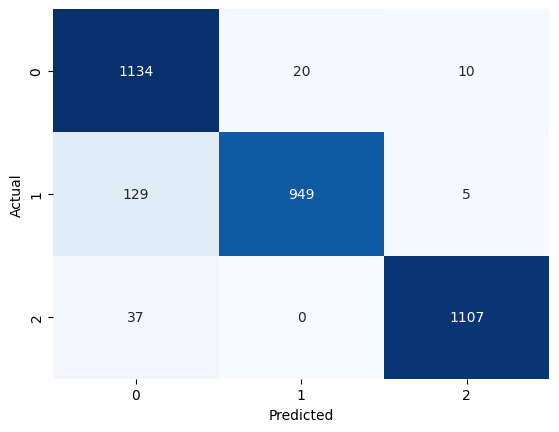

In [32]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

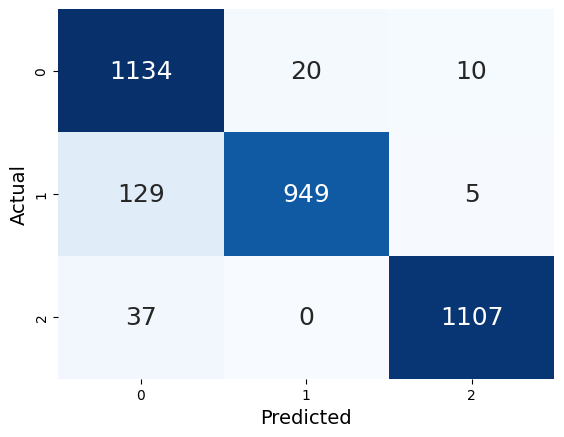

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = [[1134,20,10], [129,949,5], [37,0,1107]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 18})
plt.xlabel('Predicted', fontsize=14)  # Adjust the font size as needed
plt.ylabel('Actual', fontsize=14)  # Adjust the font size as needed
plt.savefig('drnse121.pdf')
plt.show()